In [34]:
import pandas as pd
import numpy as np
import re #used as a regular expression to find particular patterns and process it
import string 

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import nltk #a natural language processing toolkit module associated in anaconda
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# # uncomment these for the first run
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

In [13]:
df = pd.read_table('./data/review_sentiment.tsv')
df.drop(columns=df.columns[0], axis=1,  inplace=True)
df.head()

,product_name,newReviewText,Sentiment
0,Kosette,good and comfy,positive
1,Kosette,Bought for the whole family for the period of ...,positive
2,Kosette,It hurts the ears a little if you wear it for ...,negative
3,Kosette,Pretty like after washing,positive
4,Kosette,4,positive


In [14]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt


df['newReviewText'] = np.vectorize(remove_pattern)(df['newReviewText'].astype(str), "@[\w]*")

In [15]:
# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text
# Removing emojis
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = to_unicode(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    text = text.encode('ascii', 'ignore')
    text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text


In [16]:
df['newReviewText'] = df['newReviewText'].apply(denoise_text)

In [17]:
#Tokenization of text
tokenizer=ToktokTokenizer() #for every function

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [18]:
from nltk.tokenize import word_tokenize,sent_tokenize

#You can either remove stopwords before or after stemming. But since this is a review context, we expect users to have used many different words and we did
# stemming before filtering for stopwords.

stop=set(stopwords.words('english'))
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
df['newReviewText']=df['newReviewText'].apply(remove_stopwords)

{'more', 'has', 'only', 'these', 'o', 'where', 'him', 'same', 're', "mustn't", 'for', 'before', 'hers', 'should', "isn't", 'mustn', 'she', 'doesn', 'this', 'they', 'hasn', 'why', 'isn', 'can', 'here', 'haven', 'll', 'had', 'ma', "mightn't", 'weren', 'herself', 'do', 'while', 'which', 'you', 'didn', 's', 'am', "didn't", 'there', 'myself', 'itself', "that'll", 'how', 'needn', "you've", 'but', 'so', "should've", 'between', 'those', 'being', 'about', 'all', 'of', 'whom', "don't", "aren't", "weren't", 'not', 'that', "haven't", 'yourself', 'with', 'such', 'any', 'after', "it's", 'each', 'or', 'until', 'who', 'doing', 'at', 'does', 'did', 'out', 'he', 'from', 'own', 'off', 'were', 'because', 't', 'your', 'against', 'themselves', 'when', 'wasn', 'up', 'was', 'their', 'ourselves', 'our', 'yours', 've', 'them', 'hadn', 'it', 'is', 'on', 'both', "doesn't", 'most', 'd', 'again', 'during', 'shouldn', 'ours', 'a', "you'll", "she's", 'shan', 'yourselves', 'y', 'her', 'further', 'very', 'be', "won't",

In [19]:
df.head()

,product_name,newReviewText,Sentiment
0,Kosette,good comfy,positive
1,Kosette,bought whole family period pandemic comfortabl...,positive
2,Kosette,hurts ears little wear long time,negative
3,Kosette,pretty like washing,positive
4,Kosette,4,positive


In [20]:
def simple_stemmer(text):
    ps = SnowballStemmer(language='english')
    return ' '.join([ps.stem(word) for word in tokenizer.tokenize(text)])

In [21]:
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word
            
def lemmatize_text(text):
    return ' '.join(lemmatize_all(text))

In [25]:
df['newReviewText'] = df['newReviewText'].apply(lemmatize_text)
df.head()

,product_name,newReviewText,Sentiment
0,Kosette,good comfy,positive
1,Kosette,bought whole family period pandemic comfortabl...,positive
2,Kosette,hurt ears little wear long time,negative
3,Kosette,pretty like wash,positive
4,Kosette,4,positive


In [74]:
pos_dict = dict()
neg_dict = dict()
for i in df.product_name.unique():
    pos_dict[i] = " ".join([sentence for sentence in df[(df['product_name']==i) & (df['Sentiment']=='positive')].newReviewText]).replace('mask','')
    neg_dict[i] = " ".join([sentence for sentence in df[(df['product_name']==i) & (df['Sentiment']=='negative')].newReviewText]).replace('mask','')

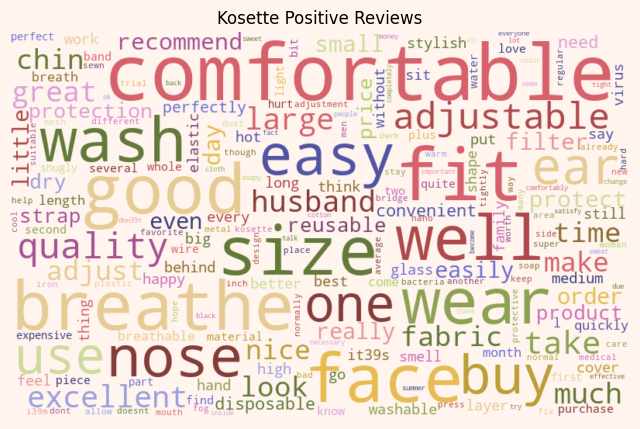

In [75]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='tab20b',collocations=False).generate(pos_dict['Kosette'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Kosette Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

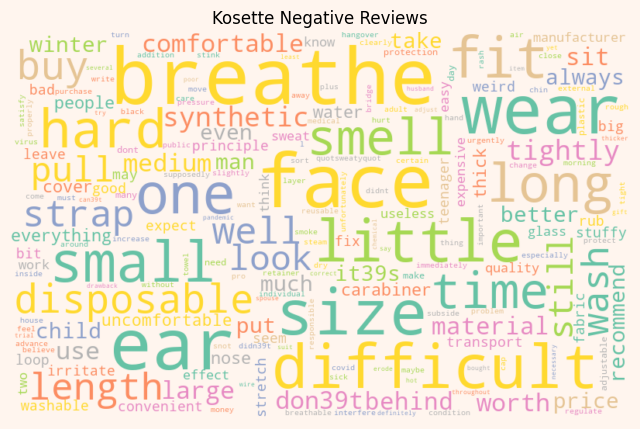

In [76]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Kosette'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Kosette Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

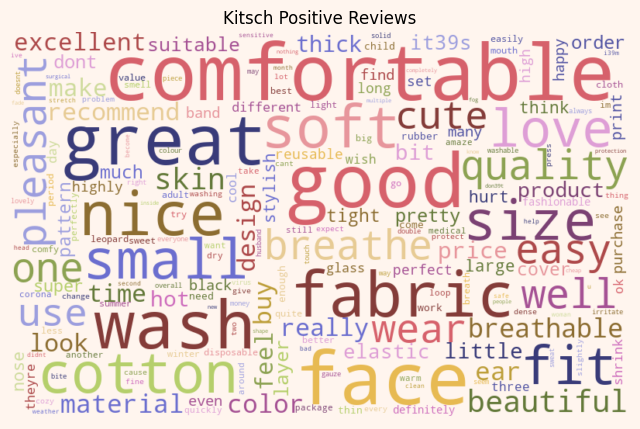

In [77]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='tab20b',collocations=False).generate(pos_dict['Kitsch'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Kitsch Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

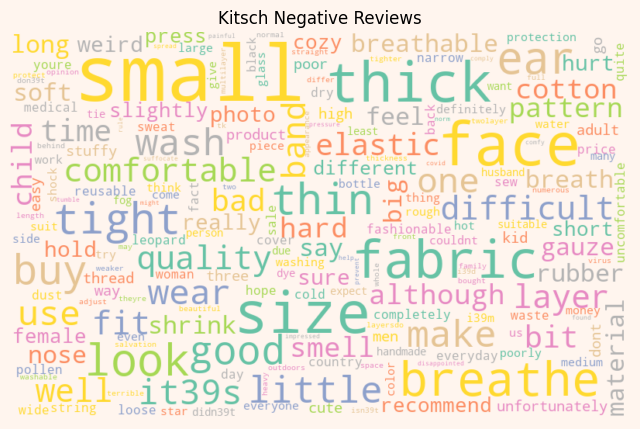

In [78]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Kitsch'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Kitsch Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

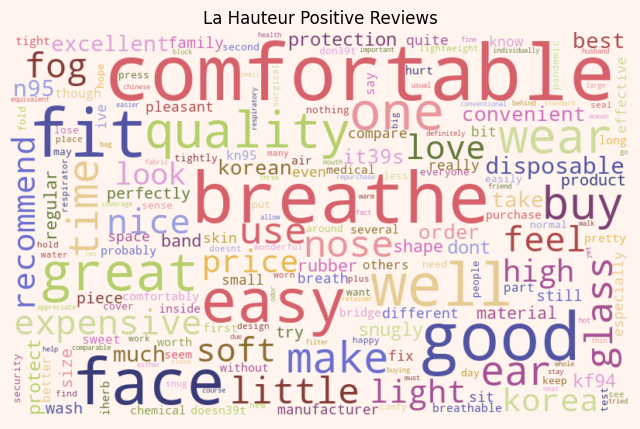

In [79]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='tab20b',collocations=False).generate(pos_dict['La Hauteur'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('La Hauteur Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

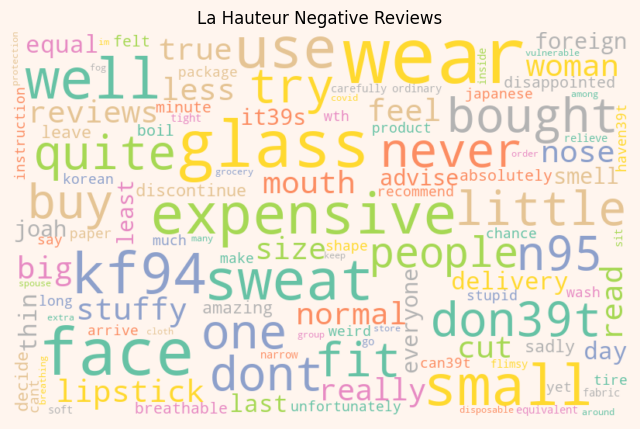

In [80]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['La Hauteur'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('La Hauteur Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

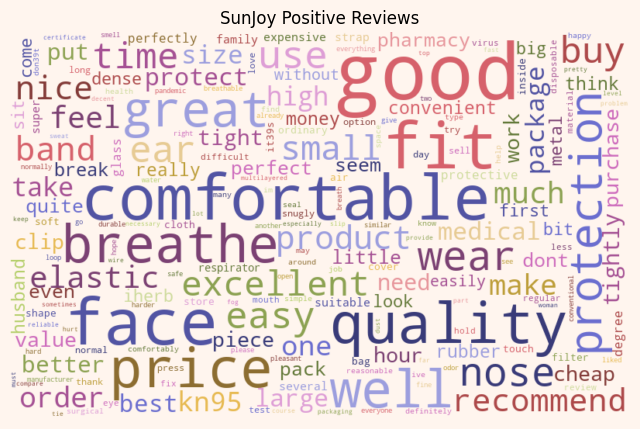

In [81]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='tab20b',collocations=False).generate(pos_dict['SunJoy'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('SunJoy Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

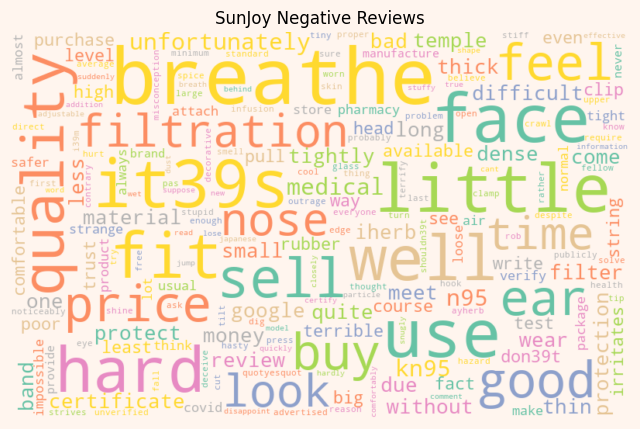

In [82]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['SunJoy'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('SunJoy Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

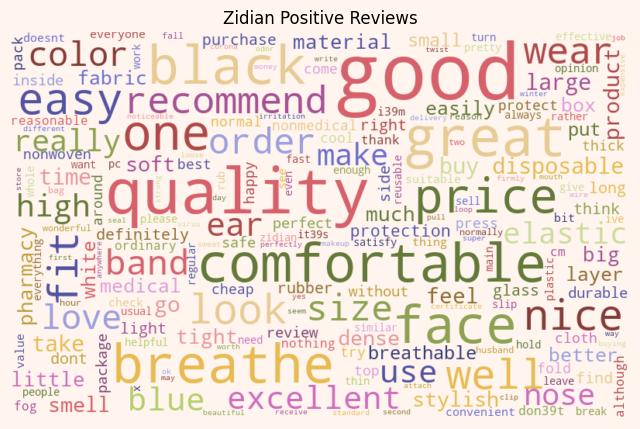

In [83]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='tab20b',collocations=False).generate(pos_dict['Zidian'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Zidian Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

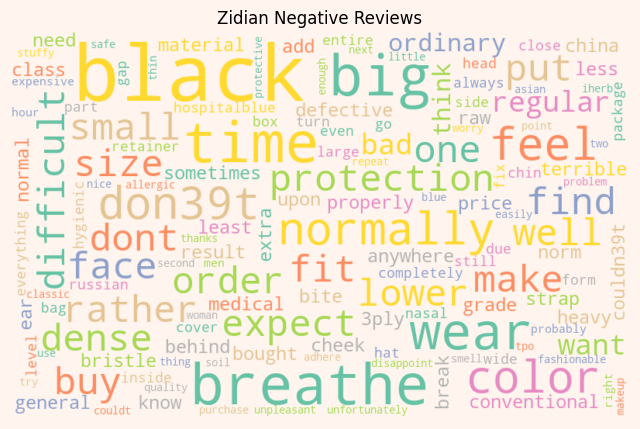

In [84]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Zidian'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Zidian Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()